# COVID-19 Visualisation Plots

In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import pandas as pd 
from matplotlib import pyplot
import time
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import datetime
from datetime import date
import matplotlib.patches as mpatches
import os

In [116]:
def plot_time_pred(true, predict,cases_type,country,arg,province):
    
    plt.subplot(arg)
    
    markers = ["." , "," , "o" , "v" , "^" , "<", ">"]
    colors = ['r','g','b','c','m', 'y', 'k','orange','white']
    
    plt.plot(true, label = 'True',marker= markers[2] , color=colors[1], linewidth=3.0,ms=10)
    plt.plot(predict['Predicted'], marker= markers[4] , color=colors[4] , label = 'Predicted', linewidth=3.0,ms=12)

    plt.xlabel('Dates', size=17)
    plt.ylabel(cases_type + ' Cases', size=17)
    
    if (cases_type == 'Confirmed'):
        low_95 = 'low95' + 'N'
        high95 = 'high95' + 'N'
    elif (cases_type == 'Death'):
        low_95 = 'low95' + 'D'
        high95 = 'high95' + 'D'
    
    plt.subplots_adjust(hspace=0.4,top=0.95)
    
    if (pd.isnull(province)):
        label = country
    else:
        label = country +'/'+ str(province)
        
    country_patch = mpatches.Patch(color= colors[8], label = label)

    country_legend = plt.legend(handles=[country_patch],loc = 'lower right',prop={'size': 17})
    plt.gca().add_artist(country_legend)
    
    plt.legend(loc = 'upper left',prop={'size': 17})

    
    plt.fill_between(predict.index,predict[low_95],  predict[high95], color='red', alpha=.3) 
    
    plt.xticks(rotation='vertical',size=17)
    plt.yticks(size=17)


In [120]:
def Visualize_Cases(pred_days_ahead,cases_type,country,arg,province):
    data_path = 'https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/'
    
    if (cases_type == 'Confirmed' and country != 'US'):
        input_data = 'time_series_covid19_confirmed_global.csv'
    elif (cases_type == 'Death' and country != 'US'):
        input_data = 'time_series_covid19_deaths_global.csv'
    elif (cases_type == 'Confirmed' and country == 'US'):
        input_data = 'time_series_covid19_confirmed_US.csv'
    elif (cases_type == 'Death' and country == 'US'):
        input_data = 'time_series_covid19_deaths_US.csv'
        
    cases = pd.read_csv(data_path + input_data)
    print("Start testing")
    print(cases.head())

    if(country != 'US'):
        drop_columns = ['Lat','Long']
    else:
        cases.rename(columns={'Province_State':'Province/State', 'Country_Region':'Country/Region', 'Long_':'Long' }, inplace=True)
        if (cases_type == 'Confirmed'):
            drop_columns = ['UID', 'iso2','iso3' ,'code3','FIPS','Admin2','Combined_Key','Lat','Long']
        else:
            drop_columns = ['UID', 'iso2','iso3' ,'code3', 'FIPS','Admin2','Combined_Key', 'Population','Long','Lat']
        
    
    cases.drop(drop_columns, inplace=True, axis=1)
    cases=cases.groupby(['Province/State','Country/Region']).sum().reset_index()
    
    colnames = cases.columns.values
    
    print(cases.head())
    #region = cases.loc[cases['Country/Region'] == country ]
    if pd.isnull(province):
        region = cases.loc[(cases['Country/Region'] == country) & (pd.isnull(cases['Province/State']))]
        print("Hello1")
    else :
        region = cases.loc[(cases['Country/Region'] == country) & (cases['Province/State'] == province)]
        print("Hello2")
    
    print(region)
    region =  np.array(region.loc[:, colnames[4]:colnames[-1]])
    print("Test end")
    #print(region)
    
    date_rng = pd.date_range(start=colnames[4], end=colnames[-1], freq='D') #creates the days
    df_true = pd.DataFrame(date_rng, columns=['date'])
    df_true['True']=np.transpose(region) #this is a dataframe with dates and cases.
    df_true = df_true.set_index('date')
    
    path = '../Predictions/'+str(pred_days_ahead)+'day_prediction/TOTAL/'
    
   # if (country == 'US'):
   #     ignored = {"2day_prediction_2020-04-13.csv", "2day_prediction_2020-04-14.csv", 
   #                "2day_prediction_2020-04-15.csv","2day_prediction_2020-04-16.csv",
   #               "2day_prediction_2020-04-17.csv","2day_prediction_2020-04-18.csv",
   #               "2day_prediction_2020-04-19.csv","2day_prediction_2020-04-20.csv"}
   #     prediction_files = [x for x in os.listdir(path) if x not in ignored]
   # else:
    prediction_files = os.listdir(path)    

    
    # Read predictions from days ahead and extract the predictions in predictions df 
    i = 0
    predictions = pd.DataFrame()
    for file in prediction_files:

        i = i+1
        pred = pd.read_csv(path + file)
        #print(pred.head())
        
        #pred = pred.loc[pred['Country'] == country]
        
        if pd.isnull(province):
            pred = pred.loc[(pred['Country'] == country) & (pd.isnull(pred['Province/State']))]
        else:
            pred = pred.loc[(pred['Country'] == country) & (pred['Province/State'] == province)]

        if (cases_type == 'Confirmed'):
            drop_columns = ['Province/State','Country',
              'R','low95R','high95R','D','low95D','high95D','T','low95T','high95T',
               'M','low95M','high95M','C','low95C','high95C']
        elif (cases_type == 'Death'):
             drop_columns = ['Province/State','Country',
              'N','low95N','high95N','R','low95R','high95R','T','low95T','high95T',
               'M','low95M','high95M','C','low95C','high95C']

        pred.drop(drop_columns, inplace=True, axis=1)

        if (i == 1):
            header = True
        else:
            header = False

        predictions = predictions.append(pred)

    if (cases_type == 'Confirmed'):
        predictions.rename(columns={'Target/Date':'date','N': 'Predicted'}, inplace=True)
    elif (cases_type == 'Death'):
        predictions.rename(columns={'Target/Date':'date','D': 'Predicted'}, inplace=True)
    predictions.set_index('date', inplace=True)
    predictions.index = pd.to_datetime(predictions.index)
    predictions = predictions.sort_values('date', ascending=True)
    
    plot_time_pred(df_true[-24:len(df_true)], predictions,cases_type,country,arg,province)
    

In [123]:
pred_days_ahead = 7
fig = plt.figure(figsize=(15, 15))
fig.suptitle('COVID-19 Cases', size=30)
Visualize_Cases(pred_days_ahead,'Confirmed','Greece',221,float('NaN'))
Visualize_Cases(pred_days_ahead,'Death','Greece',222,float('NaN'))
Visualize_Cases(pred_days_ahead,'Confirmed','Portugal',223,float('NaN'))
Visualize_Cases(pred_days_ahead,'Death','Portugal',224,float('NaN'))

plt.show()
fig.savefig('Predictions.pdf', bbox_inches='tight')     
fig.savefig('Predictions.png', bbox_inches='tight')     

Start testing
  Province/State Country/Region      Lat     Long  1/22/20  1/23/20  1/24/20  \
0            NaN    Afghanistan  33.0000  65.0000        0        0        0   
1            NaN        Albania  41.1533  20.1683        0        0        0   
2            NaN        Algeria  28.0339   1.6596        0        0        0   
3            NaN        Andorra  42.5063   1.5218        0        0        0   
4            NaN         Angola -11.2027  17.8739        0        0        0   

   1/25/20  1/26/20  1/27/20  ...  5/31/20  6/1/20  6/2/20  6/3/20  6/4/20  \
0        0        0        0  ...    15205   15750   16509   17267   18054   
1        0        0        0  ...     1137    1143    1164    1184    1197   
2        0        0        0  ...     9394    9513    9626    9733    9831   
3        0        0        0  ...      764     765     844     851     852   
4        0        0        0  ...       86      86      86      86      86   

   6/5/20  6/6/20  6/7/20  6/8/20  6

ValueError: Wrong number of items passed 0, placement implies 1

<Figure size 1080x1080 with 0 Axes>

Start testing
   UID iso2 iso3  code3  FIPS Admin2            Province_State Country_Region  \
0   16   AS  ASM     16  60.0    NaN            American Samoa             US   
1  316   GU  GUM    316  66.0    NaN                      Guam             US   
2  580   MP  MNP    580  69.0    NaN  Northern Mariana Islands             US   
3  630   PR  PRI    630  72.0    NaN               Puerto Rico             US   
4  850   VI  VIR    850  78.0    NaN            Virgin Islands             US   

       Lat     Long_  ... 5/31/20  6/1/20  6/2/20  6/3/20  6/4/20  6/5/20  \
0 -14.2710 -170.1320  ...       0       0       0       0       0       0   
1  13.4443  144.7937  ...     172     175     175     177     179     179   
2  15.0979  145.6739  ...      22      22      23      24      26      26   
3  18.2208  -66.5901  ...    3776    3873    3935    4023    4508    4620   
4  18.3358  -64.8963  ...      69      70      70      70      71      71   

   6/6/20  6/7/20  6/8/20  6/9/20  


/home/iliana/anaconda3/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


Start testing
   UID iso2 iso3  code3  FIPS Admin2            Province_State Country_Region  \
0   16   AS  ASM     16  60.0    NaN            American Samoa             US   
1  316   GU  GUM    316  66.0    NaN                      Guam             US   
2  580   MP  MNP    580  69.0    NaN  Northern Mariana Islands             US   
3  630   PR  PRI    630  72.0    NaN               Puerto Rico             US   
4  850   VI  VIR    850  78.0    NaN            Virgin Islands             US   

       Lat     Long_  ... 5/31/20  6/1/20  6/2/20  6/3/20  6/4/20  6/5/20  \
0 -14.2710 -170.1320  ...       0       0       0       0       0       0   
1  13.4443  144.7937  ...     172     175     175     177     179     179   
2  15.0979  145.6739  ...      22      22      23      24      26      26   
3  18.2208  -66.5901  ...    3776    3873    3935    4023    4508    4620   
4  18.3358  -64.8963  ...      69      70      70      70      71      71   

   6/6/20  6/7/20  6/8/20  6/9/20  


/home/iliana/anaconda3/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


Start testing
   UID iso2 iso3  code3  FIPS Admin2            Province_State Country_Region  \
0   16   AS  ASM     16  60.0    NaN            American Samoa             US   
1  316   GU  GUM    316  66.0    NaN                      Guam             US   
2  580   MP  MNP    580  69.0    NaN  Northern Mariana Islands             US   
3  630   PR  PRI    630  72.0    NaN               Puerto Rico             US   
4  850   VI  VIR    850  78.0    NaN            Virgin Islands             US   

       Lat     Long_  ... 5/31/20  6/1/20  6/2/20  6/3/20  6/4/20  6/5/20  \
0 -14.2710 -170.1320  ...       0       0       0       0       0       0   
1  13.4443  144.7937  ...       5       5       5       5       5       5   
2  15.0979  145.6739  ...       2       2       2       2       2       2   
3  18.2208  -66.5901  ...     136     136     138     140     140     141   
4  18.3358  -64.8963  ...       6       6       6       6       6       6   

   6/6/20  6/7/20  6/8/20  6/9/20  


/home/iliana/anaconda3/lib/python3.7/site-packages/pandas/core/ops.py:1649: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


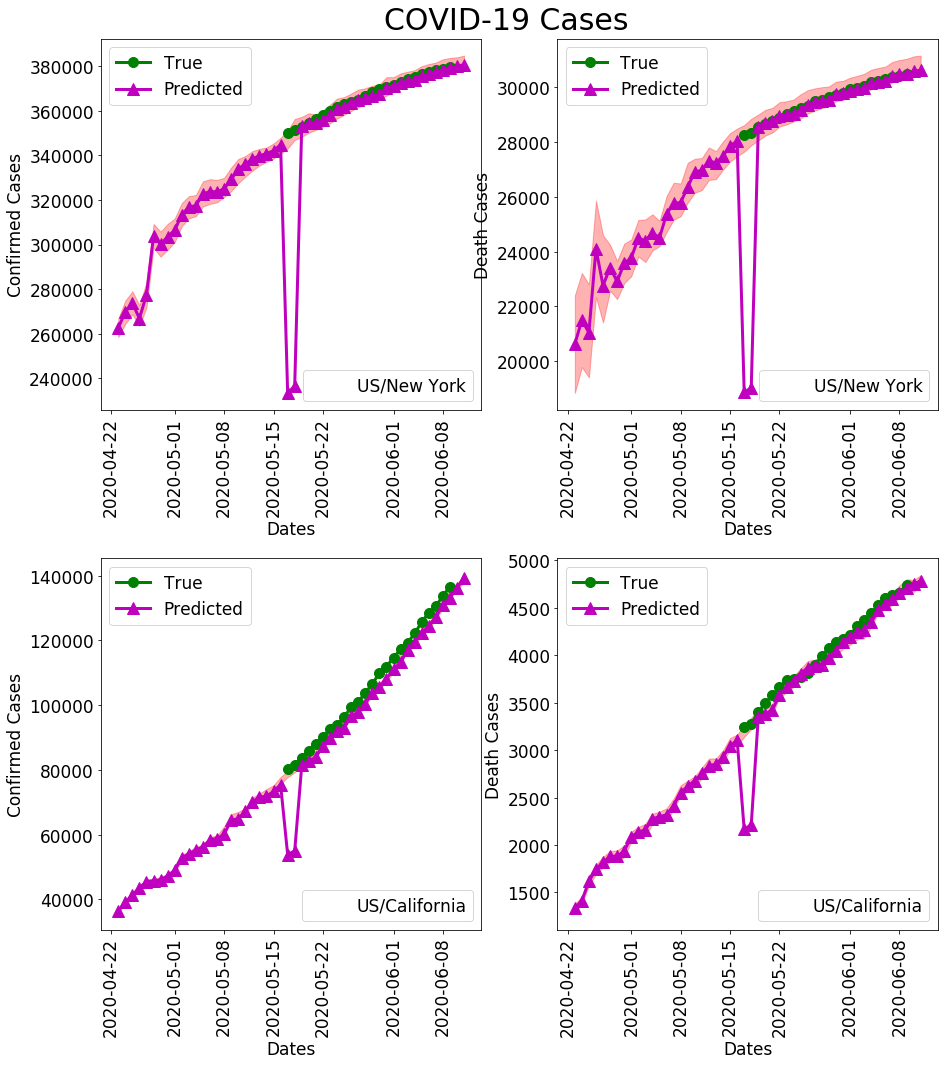

In [126]:
pred_days_ahead = 2
fig = plt.figure(figsize=(15, 15))
fig.suptitle('COVID-19 Cases', size=30)
Visualize_Cases(pred_days_ahead,'Confirmed','US',221,'New York')
Visualize_Cases(pred_days_ahead,'Death','US',222,'New York')
Visualize_Cases(pred_days_ahead,'Confirmed','US',223,'California')
Visualize_Cases(pred_days_ahead,'Death','US',224,'California')
plt.show()
fig.savefig('Predictions.pdf', bbox_inches='tight')     
fig.savefig('Predictions.png', bbox_inches='tight') 